# Figures with Dynamics

This notebook is intended to provide figures relating to the *dynamics* of the models we are discussing. Figures related to *inference* are handled in separate notebooks for each data set. 

In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

# from SpringRank import SpringRank

from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

# Setup: 

In [63]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [3]:
@jit(nopython=True)
def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

# Detailed bifurcations: SpringRank

In [25]:
n = 20

A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

lam = .85
n_rounds = 10000

b_grid = 101
BETAS = np.linspace(1,5, b_grid)

V = np.zeros((b_grid, n))

M = model()
M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
M.set_features([linear_feature])

for j in range(b_grid):

    M.simulate(beta = np.array([BETAS[j]]), 
                       lam = lam, 
                       A0 = A0, 
                       n_rounds = n_rounds, 
                       update = deterministic_update, 
                       m_updates = m_updates)
    GAMMA = M.get_rates()
    GAMMA = np.sort(GAMMA, axis = 2)
    V[j] = GAMMA[(-1000):(-1)].mean(axis = (0,1))

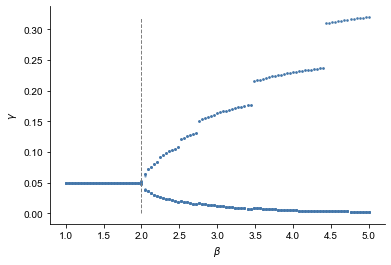

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(V.shape[1]):
    p = ax.scatter(BETAS, V[:,i], color = cset[0], alpha = 0.5, s=2)

ax.vlines(x = 2, ymin = 0, ymax = V.max(), linestyle = 'dashed', linewidth = 1, color = 'grey')    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set(xlabel = r'$\beta$')
ax.set(ylabel = r'$\gamma$')

plt.savefig('fig/SR_bifurcation_detail.png', bbox_inches = 'tight')

# Comparison of Bifurcations with alternate score functions

In [3]:
# Params

A = np.sqrt(np.random.rand(n,n))
A0 = A/A.sum()
lam = .995

In [8]:
scores = {
    'SpringRank': lambda A: homebrew_SpringRank_score(A.T),
    'Root-Degree' : lambda A: powered_degree_score(A, 1/2), 
    'Fiedler Vector' : lambda A: -fiedler_vector_score(A)
}

transition_predictions = {
    'SpringRank': 2, 
    'Root-Degree': 2*n**(1/2),
    'Fiedler Vector': 0
}

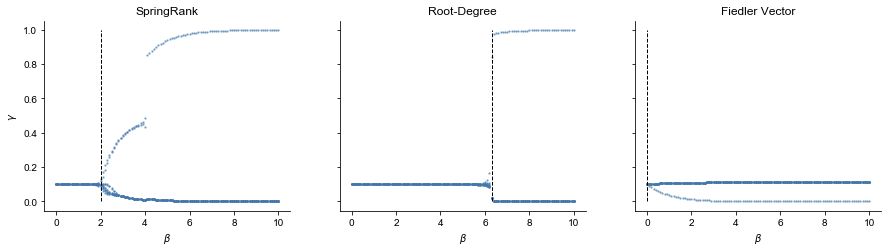

In [11]:
b_grid = 101

n_rounds = 50000

n = 10
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()

BETAS = {
    'SpringRank' : np.linspace(0, 10, b_grid), 
    'Root-Degree': np.linspace(0,10, b_grid),
    'Fiedler Vector' : np.linspace(0,10,b_grid),
}

lam = .995

score_names = ['SpringRank','Root-Degree', 'Fiedler Vector']

k = len(score_names)

fig, axarr = plt.subplots(1,k, figsize = (15, 3.5), sharey = True)

for i in range(k):
    
    M = model()
    M.set_score(score_function = scores[score_names[i]])
    M.set_features([linear_feature])
    
    V = np.zeros((b_grid, n))
    
    for j in range(b_grid):
        M.simulate(beta = np.array([BETAS[score_names[i]][j]]), 
                   lam = lam, 
                   A0 = A0, 
                   n_rounds = n_rounds, 
                   update = deterministic_update, 
                   m_updates = m_updates)
        GAMMA = M.get_rates()
        GAMMA = np.sort(GAMMA, axis = 2)
        V[j] = GAMMA[-1].mean(axis = 0)
    
    if k == 1:
        ax = axarr
    else:
        ax = axarr[i]
    
    for j in range(V.shape[1]):
        p = ax.scatter(BETAS[score_names[i]], V[:,j], color = cset[0], alpha = 0.5, s=2)

#     p = ax.plot(BETAS[score_names[i]], V, color = 'grey', alpha = .5)
    
    v = ax.vlines(x = [transition_predictions[score_names[i]]], 
                        ymin = 0, 
                        ymax = 1, 
                        linewidth = 1, 
                        linestyle = 'dashed')
    
    t = ax.set_title(score_names[i])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
#     color = '#4d4d4d'
#     for pos in ['bottom', 'left']: 
#         ax.spines[pos].set_color('#4d4d4d')
#         ax.tick_params(axis='x', colors='#4d4d4d', which='both')
        
#         ax.yaxis.label.set_color('#4d4d4d')
#         ax.xaxis.label.set_color('#4d4d4d')
#         ax.title.set_color('#4d4d4d')
    
    ax.set(xlabel = r'$\beta$')
    
    if i == 0:
        ax.set(ylabel = r'$\gamma$')
    
plt.savefig('fig/phase_transitions.png', bbox_inches = 'tight', dpi = 300)

# Comparison: Impact of quadratic features

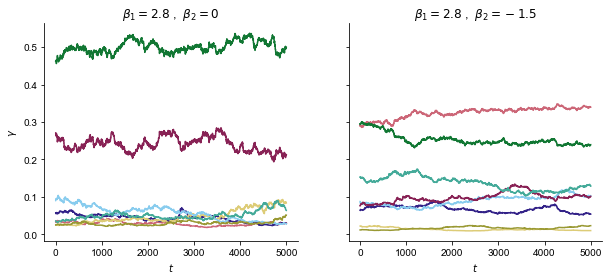

In [73]:
def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

lam = .998
n_rounds = 10000
m_updates = 1

n = 8
A0 = np.random.rand(n,n)
A0 = A0/A0.sum()


fig, axarr = plt.subplots(1,2, figsize = (10, 4), sharey = True)

M = model()
M.set_score(score_function = lambda A: homebrew_SpringRank_score(A.T))
M.set_features([linear_feature, 
                quadratic_feature])

M.simulate(beta = np.array([2.8, 0]), 
           lam = lam, 
           A0 = A0, 
           n_rounds = n_rounds, 
           update = stochastic_update, 
           m_updates = m_updates)
GAMMA = M.get_rates()

for j in range(n):
    p = axarr[0].plot(GAMMA.mean(axis = 1)[5000:,j], color = cset_muted[j])

M.simulate(beta = np.array([2.8, -1.5]), 
           lam = lam, 
           A0 = A0, 
           n_rounds = n_rounds, 
           update = stochastic_update, 
           m_updates = m_updates)
GAMMA = M.get_rates()
for j in range(n):
    p = axarr[1].plot(GAMMA.mean(axis = 1)[5000:,j], color = cset_muted[j])


for ax in axarr:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(xlabel = r'$t$')
    
axarr[0].set(ylabel = r'$\gamma$')
axarr[0].set_title(r'$\beta_1 = 2.8\;$, $\;\beta_2 = 0$')
axarr[1].set_title(r'$\beta_1 = 2.8\;$, $\;\beta_2 = -1.5$')

plt.savefig('fig/SR_linear_and_quadratic.png', bbox_inches = 'tight', dpi = 300)